<a href="https://colab.research.google.com/github/rubyblackburn/CognitiveAICoursework/blob/main/CogAI_coursework_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .


Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793130 sha256=947b48760841552d9c02574f4d6e853d724c66954721477c4e55ef45f73b63f0
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found exist

### Importing common packages

In [ ]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# IMPORT NEUROGYM TO CREATE DATASET SPECIFIC TO TASK

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)


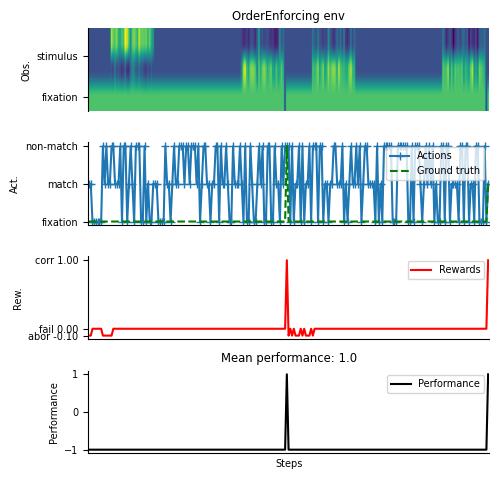

In [ ]:
#Importing neurogym
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Canned environment from neurogym
# Copy the name of the Perceptual Decision Making environment from here: https://neurogym.github.io/envs/index.html
task = 'DelayMatchSample-v0'

# Define task-specific timing parameters
timing = {'stimulus': ('constant', 1000)}

kwargs = {'dt': 20, 'timing': timing}


# Make supervised dataset
batch_size = 16
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size,
                       seq_len=seq_len)
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)


print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)
# A sample environment from dataset
env = dataset.env

input_size = env.observation_space.shape[0]
output_size = env.action_space.n
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n


*********************

*****************

*************

# Leaky RNN Model

In [ ]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output






##*************dimensions of inputs and outputs:*********************************
#batch_size = 16
#seq_len = 20  # sequence length
#input_size = 4  # input dimension

# Make some random inputs
#input_rnn = torch.rand(seq_len, batch_size, input_size)
# NOTE INSTEAD WE WANT THE INPUTS FROM THE TRAINING TASK

## Make network of 100 hidden units and 10 output units
#rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

## Run the sequence through the network
#out, rnn_output = rnn(inputs)

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.3540, Time 5.5s
Step 200, Loss 0.2164, Time 9.7s
Step 300, Loss 0.2042, Time 13.7s
Step 400, Loss 0.1996, Time 18.9s
Step 500, Loss 0.1940, Time 22.9s
Step 600, Loss 0.1928, Time 27.0s
Step 700, Loss 0.1941, Time 32.3s
Step 800, Loss 0.1893, Time 36.6s
Step 900, Loss 0.1907, Time 40.7s
Step 1000, Loss 0.1914, Time 46.0s
Step 1100, Loss 0.1879, Time 50.1s
Step 1200, Loss 0.1892, Time 54.2s
Step 1300, Loss 0.1903, Time 59.4s
Step 1400, Loss 0.1864, Time 63.6s
Step 1500, Loss 0.1891, Time 67.7s
Step 1600, Loss 0.1900, Time 72.8s
Step 1700, Loss 0.1884, Time 77.0s
Step 1800, Loss 0.1891, Time 81.3s
Step 1900, Loss 0.1900, Time 86.3s
Step 2000, Loss 0.1878, Time 90.6s


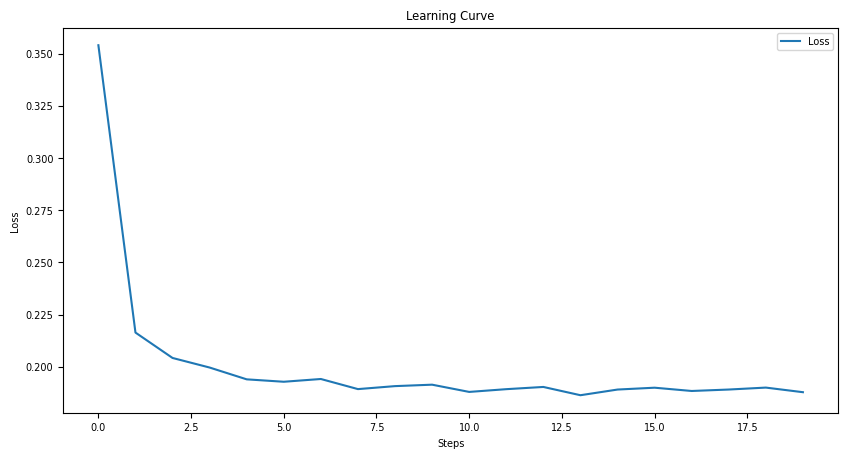

In [ ]:
# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    loss_values = []
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(2000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            loss_values.append(running_loss)
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net, loss_values

net, loss_values = train_model(net, dataset)

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# @title Run the network post-training and record neural activity with hierarchical reasoning

env.reset(no_step=True)
# env.timing.update({'fixation': ('constant', 500),
#                    'stimulus': ('constant', 500)})
# env.generate_epoch_indices()

print(env.start_ind.keys())
print(env.end_ind.keys())

perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]
    stim_activity[env.trial['ground_truth']-1].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


dict_keys(['fixation', 'sample', 'delay', 'test', 'decision'])
dict_keys(['fixation', 'sample', 'delay', 'test', 'decision'])
Average performance 0.502


Text(0, 0.5, 'Activity')

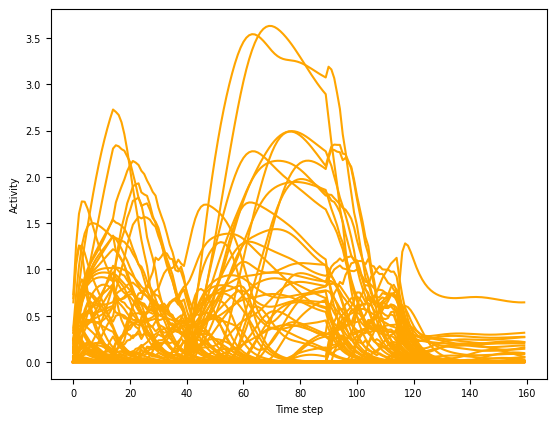

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import matplotlib.pyplot as plt

input_size = net.rnn.input_size
trial = 2

plt.figure()
# Plot activity of all neurons in a single color (e.g., black)
_ = plt.plot(activity_dict[trial], color='orange', label='All Neurons')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d' for all neurons (no separation)
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity for all neurons
ind_sort = np.argsort(selectivity)

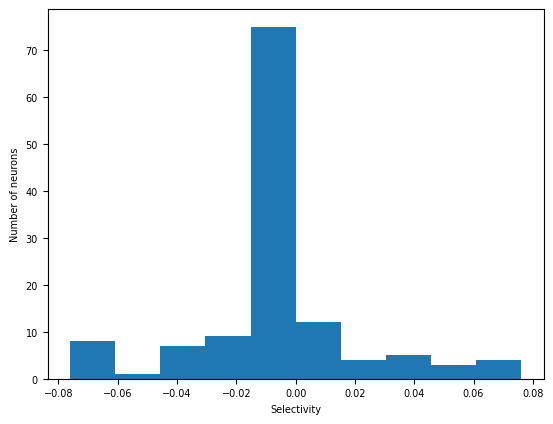

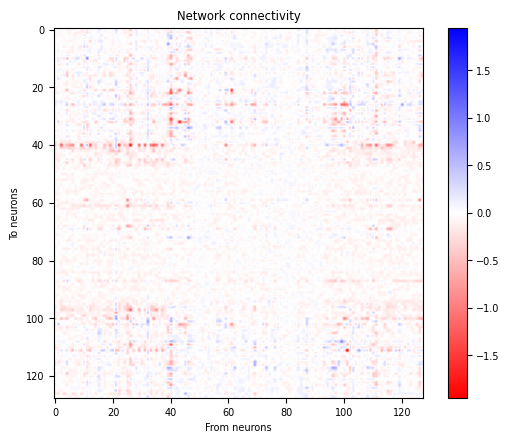

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.weight.detach().numpy()  # Access weight directly
# Sort by selectivity (for all neurons)
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

# Sort weight matrix
W = net.rnn.h2h.weight.detach().numpy()  # Access recurrent weights directly
W_sorted = W[ind_sort, :][:, ind_sort]   # Sort both rows and columns based on selectivity

Shape of the neural activity (Time points, Neurons): (80000, 128)
Shape of the projected activity (Time points, PCs): (80000, 2)
Explained variance by PC1: 0.74, PC2: 0.13
Total explained variance by 2 PCs: 86.37%


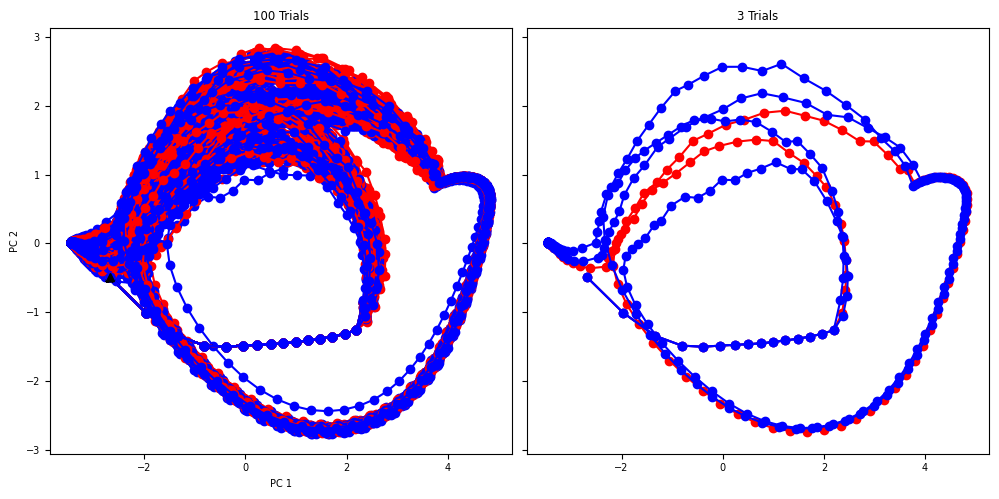

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

# Suppress excessive logging
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

# Number of trials to analyze
num_trial = 500

# Time points to visualize
plot_until_time = 200

# Gather activity data across trials
# Ensure activity_dict is populated during the model evaluation process
activity = np.concatenate([activity_dict[i] for i in activity_dict.keys()], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Perform PCA on the neural activity
pca = PCA(n_components=2)  # Use 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Project to lower dimensions
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Report the explained variance ratio for the components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}")
print(f"Total explained variance by 2 PCs: {sum(explained_variance) * 100:.2f}%")

# Visualize the PCA projections
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Loop through each trial
for i in range(100):  # Analyze and plot up to 100 trials
    trial_activity = activity_dict[i]  # Extract activity for the current trial
    trial_pc = pca.transform(trial_activity)  # Transform the trial activity

    # Color trials based on ground truth
    trial_info = trial_infos[i]
    color = 'red' if trial_info['ground_truth'] == 1 else 'blue'

    # Plot the trial data in the PCA space
    ax1.plot(trial_pc[:plot_until_time, 0], trial_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # For clarity, show only 3 trials on the second plot
        ax2.plot(trial_pc[:plot_until_time, 0], trial_pc[:plot_until_time, 1], 'o-', color=color)

    # Highlight the trial start with a black marker
    ax1.plot(trial_pc[0, 0], trial_pc[0, 1], '^', color='black')

# Add titles, labels, and adjust the layout
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


## Lesioning

In [ ]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
import torch
import torch.optim as optim

lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 100, Lesioned Network Loss 0.2171
Step 200, Lesioned Network Loss 0.2201
Step 300, Lesioned Network Loss 0.2163


In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
# !pip install -r requirements-torch

# Install dependencies
# !pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN



unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym


## Fixed Points Analysis

In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
# !pip install -r requirements-torch

# Install dependencies
# !pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym


In [ ]:
 !git clone https://github.com/mattgolub/fixed-point-finder

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [ ]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		2545 iters
		q = 3.04e-13 +/- 9.11e-13
		dq = 2.01e-16 +/- 4.03e-16
		learning rate = 1.03e-04
		avg iter time = 1.34e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



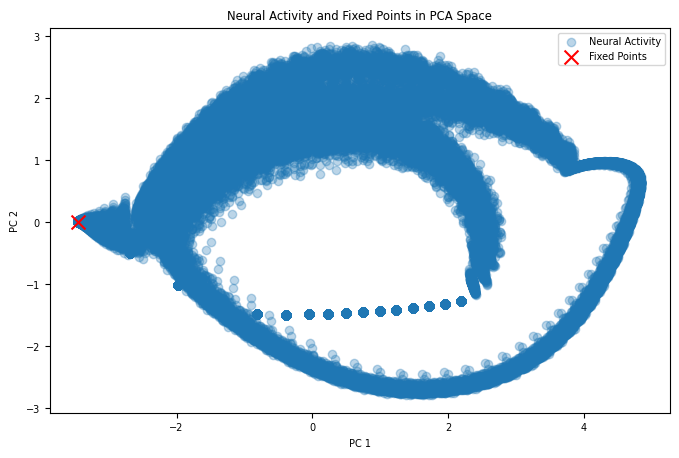

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		304 iters
		q = 3.04e-13 +/- 1.70e-13
		dq = 3.73e-13 +/- 3.29e-13
		learning rate = 4.88e-01
		avg iter time = 1.23e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		503 iters
		q = 9.25e-13 +/- 2.24e-14
		dq = 9.77e-14 +/- 4.25e-14
		learning r

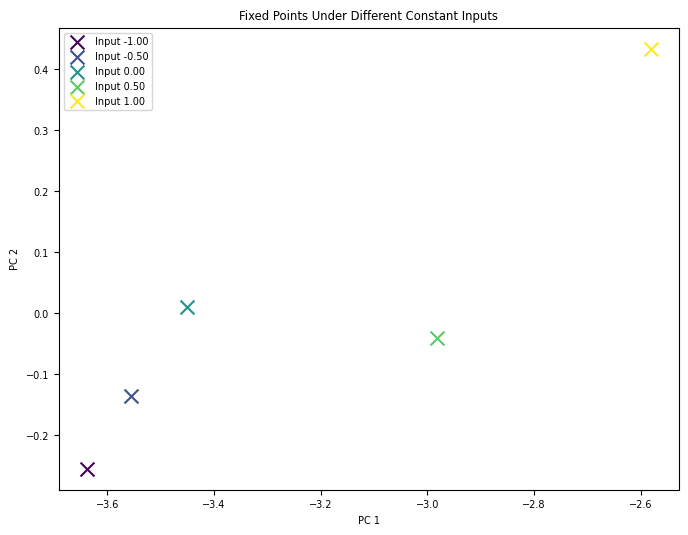

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()

**************

********************

**********************

# Leaky RNN model with more brainlike features (excitatory and inhibitory neurons for Dale's Law)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)



class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden



class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 100, Loss 0.7122
Step 200, Loss 0.3974
Step 300, Loss 0.3216
Step 400, Loss 0.2975
Step 500, Loss 0.2817
Step 600, Loss 0.2694
Step 700, Loss 0.2629
Step 800, Loss 0.2522
Step 900, Loss 0.2455
Step 1000, Loss 0.2422
Step 1100, Loss 0.2354
Step 1200, Loss 0.2335
Step 1300, Loss 0.2320
Step 1400, Loss 0.2261
Step 1500, Loss 0.2241
Step 1600, Loss 0.2252
Step 1700, Loss 0.2198
Step 1800, Loss 0.2185
Step 1900, Loss 0.2194
Step 2000, Loss 0.2151


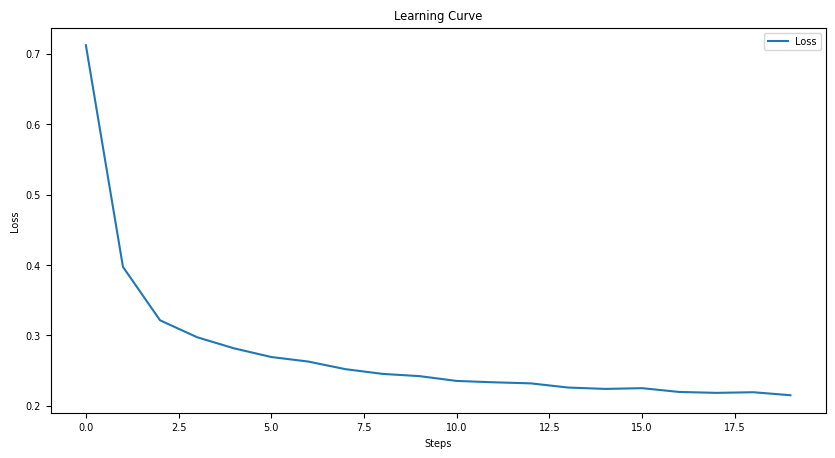

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 100
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]
    stim_activity[env.trial['ground_truth']-1].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.496


Text(0, 0.5, 'Activity')

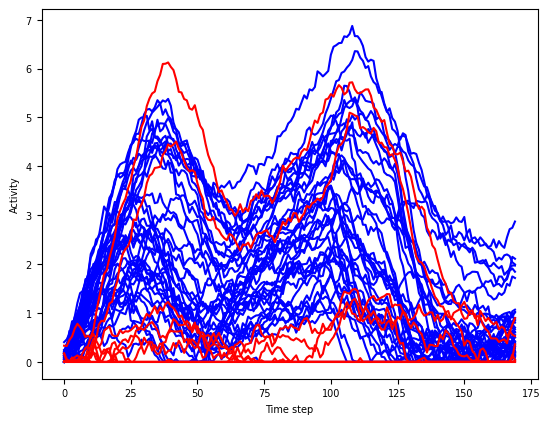

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))


Text(0.5, 1.0, 'Network connectivity')

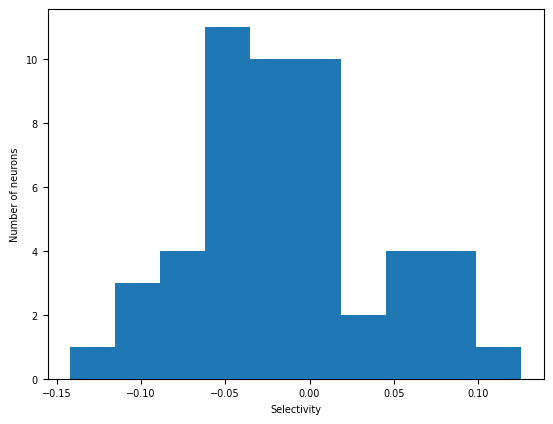

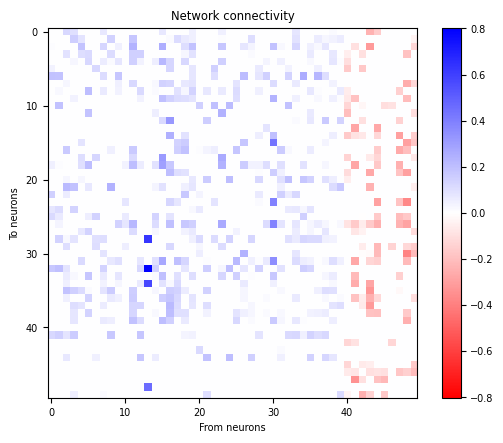

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

Shape of the neural activity (Time points, Neurons): (85000, 50)
Shape of the projected activity (Time points, PCs): (85000, 2)
Explained variance by PC1: 0.79, PC2: 0.13
Total explained variance by 2 PCs: 92.43%


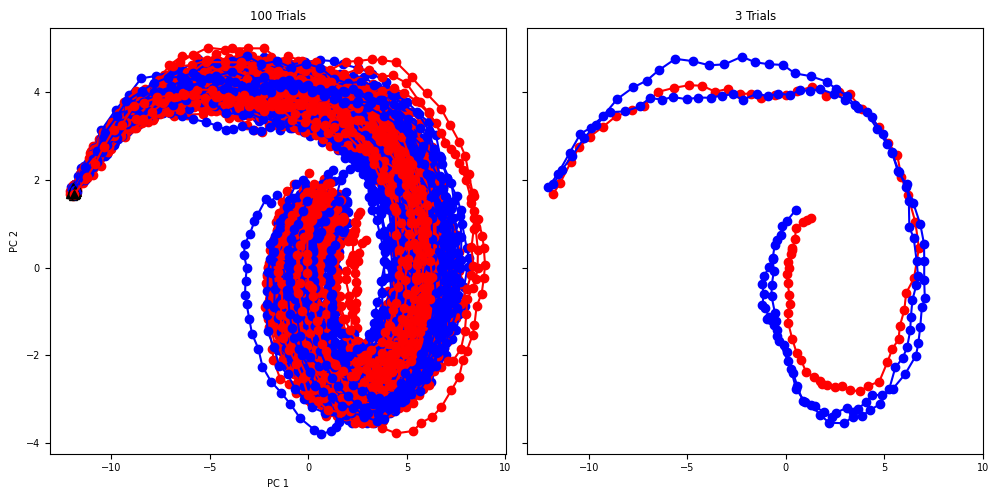

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Report the explained variance ratio for the components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}")
print(f"Total explained variance by 2 PCs: {sum(explained_variance) * 100:.2f}%")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

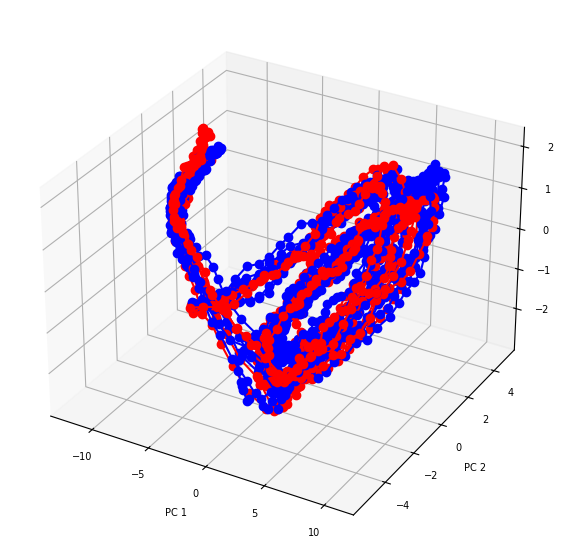

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(activity)
activity_pc = pca.transform(activity)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):  # Plot fewer trials for clarity
    trial_pc = pca.transform(activity_dict[i])
    trial_info = trial_infos[i]
    color = 'red' if trial_info['ground_truth'] == 1 else 'blue'
    ax.plot(trial_pc[:, 0], trial_pc[:, 1], trial_pc[:, 2], 'o-', color=color)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

### Lesioning

In [ ]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 100, Lesioned Network Loss 0.6133
Step 200, Lesioned Network Loss 0.6324
Step 300, Lesioned Network Loss 0.6150


In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
# !pip install -r requirements-torch

# Install dependencies
# !pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN


unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym


In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        if not isinstance(hidden, tuple):  # Assume it has both state, output
            hidden = (hidden, hidden) # Duplicate as a work around

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # If hidden is tuple, merge into a single tensor for consistency
        if isinstance(hidden, tuple):
            hidden = hidden[0] # Taking the first element if it's a tuple or list

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [ ]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net.rnn.input_size)  # Zero input for each initial condition
#should be: inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 2.20e-01 +/- 4.95e-02
		dq = 7.05e-02 +/- 5.09e-02
		learning rate = 1.97e-07
		avg iter time = 1.43e-03 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



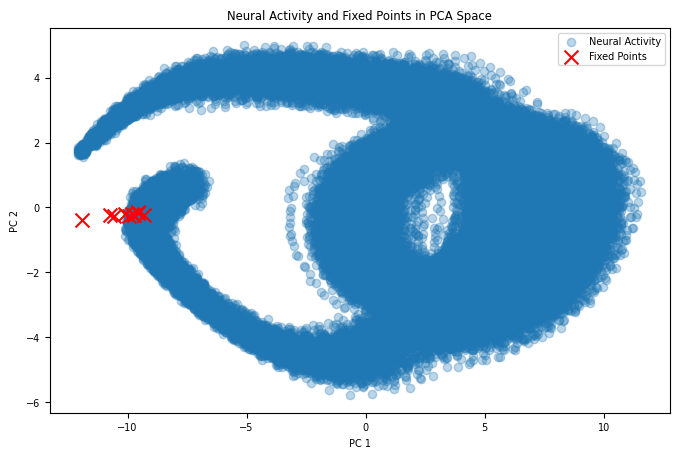

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()

**********************

******************

*******************

# DENDRITIC ERROR MODEL

In [ ]:
import torch
import torch.nn as nn

class LeakyRNNDenErrMod(nn.Module):
    """Leaky RNN with dendritic error model, using the corrected Leaky RNN dynamics.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: Discretization time step in ms (optional)

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
               if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, dt=None, learning_rate=0.01, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100  # Time constant (ms)
        self.learning_rate = learning_rate  # Learning rate for dendritic error rule

        if dt is None:
            self.alpha = 1  # No discretization
        else:
            self.alpha = dt / self.tau  # Discretization factor

        # Layers for the RNN: input to hidden and hidden to hidden
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        """Initialize hidden state to zeros."""
        batch_size = input_shape[1]  # Batch size is the second dimension
        return torch.zeros(batch_size, self.hidden_size)

    def update_weights(self, input, hidden, dendritic_voltage, error):
        """Update the weights using the dendritic error rule."""
        # Calculate the voltage difference between the dendrite (dendritic_voltage) and the cell body (hidden)
        voltage_difference = dendritic_voltage - hidden  # Represents g(delta2) - g(x2)

        # Weight update rule based on the difference and firing rate (input activity)
        self.input2h.weight.data += self.learning_rate * torch.outer(input, voltage_difference * error)
        self.h2h.weight.data += self.learning_rate * torch.outer(hidden, voltage_difference * error)

    def recurrence(self, input, hidden, target=None):
        """Run the network for one time step and compute the error signal."""
        # Compute new activity
        dendritic_voltage = torch.relu(self.input2h(input) + self.h2h(hidden))

        # If we have a target (for supervised learning), compute the error
        error = None
        if target is not None:
            error = target - dendritic_voltage  # Error term: target - dendritic_voltage

        # Update the dendritic voltage and weights if error is present
        if error is not None:
            self.update_weights(input, hidden, dendritic_voltage, error)

        # Leaky integrate: maintain some of the previous hidden state
        h_new = hidden * (1 - self.alpha) + dendritic_voltage * self.alpha
        return h_new, error

    def forward(self, input, target=None, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))  # Loop over time steps

        for i in steps:
            hidden, error = self.recurrence(input[i], hidden, target[i] if target is not None else None)
            output.append(hidden)

        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNDenErrNet(nn.Module):
    """Recurrent network model with dendritic error rule.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    """
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, **kwargs):
        super().__init__()

        # Leaky RNN layer
        self.rnn = LeakyRNNDenErrMod(input_size, hidden_size, learning_rate=learning_rate, **kwargs)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, target=None):
        rnn_output, _ = self.rnn(x, target)  # Get hidden activations from RNN
        out = self.fc(rnn_output)  # Compute final output
        return out, rnn_output





Training network...
Step 100, Loss 0.6021
Step 200, Loss 0.3737
Step 300, Loss 0.2922
Step 400, Loss 0.2616
Step 500, Loss 0.2488
Step 600, Loss 0.2462
Step 700, Loss 0.2374
Step 800, Loss 0.2332
Step 900, Loss 0.2337
Step 1000, Loss 0.2273
Step 1100, Loss 0.2242
Step 1200, Loss 0.2248
Step 1300, Loss 0.2195
Step 1400, Loss 0.2179
Step 1500, Loss 0.2195
Step 1600, Loss 0.2152
Step 1700, Loss 0.2136
Step 1800, Loss 0.2149
Step 1900, Loss 0.2095
Step 2000, Loss 0.2092


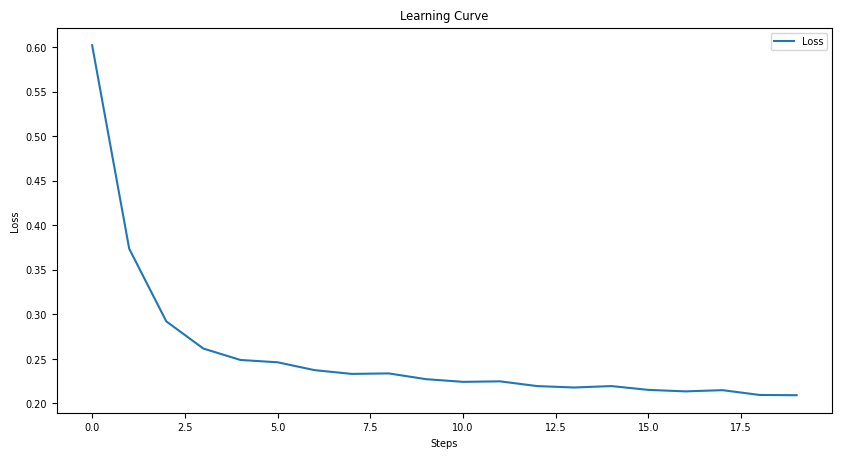

In [ ]:
# Training the corrected Leaky RNN with dendritic error model
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(net, dataset, num_steps=2000, lr=0.001):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produces a (input, target output) pair
        num_steps: Number of training steps
        lr: Learning rate for the optimizer

    Returns:
        net: network object after training
        loss_values: list of loss values during training
    """
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    running_loss = 0.0
    print_step = 100

    print('Training network...')
    for i in range(num_steps):
        # Generate input and target, convert to PyTorch tensors
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # Boilerplate PyTorch training:
        optimizer.zero_grad()
        output, activity = net(inputs)
        output = output.view(-1, output_size)  # Reshape to (SeqLen x Batch, OutputSize)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Record and print running loss
        running_loss += loss.item()
        if i % print_step == (print_step - 1):
            avg_loss = running_loss / print_step
            print(f'Step {i+1}, Loss {avg_loss:.4f}')
            loss_values.append(avg_loss)
            running_loss = 0.0

    return net, loss_values


# Training example
hidden_size = 50
net = RNNDenErrNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
net, loss_values = train_model(net, dataset)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.title('Learning Curve')
plt.plot(loss_values, label='Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]
    stim_activity[env.trial['ground_truth']-1].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.542


Text(0, 0.5, 'Activity')

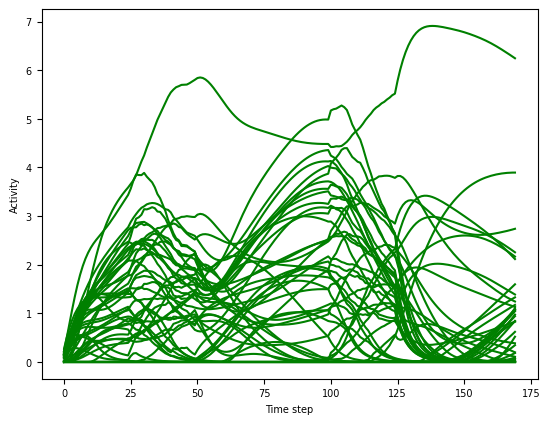

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import matplotlib.pyplot as plt

input_size = net.rnn.input_size
trial = 2

plt.figure()
# Plot activity of all neurons in a single color (e.g., black)
_ = plt.plot(activity_dict[trial], color='green', label='All Neurons')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d' for all neurons (no separation)
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity for all neurons
ind_sort = np.argsort(selectivity)

Text(0.5, 1.0, 'Network connectivity')

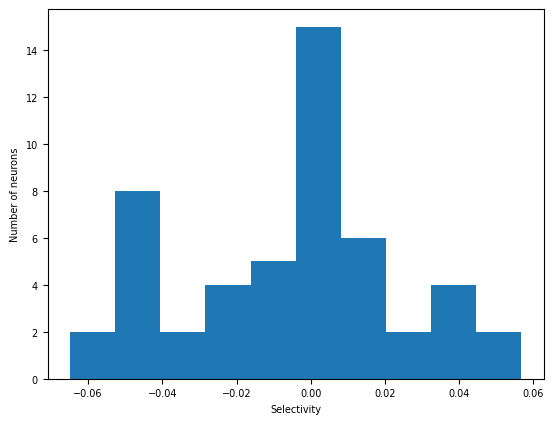

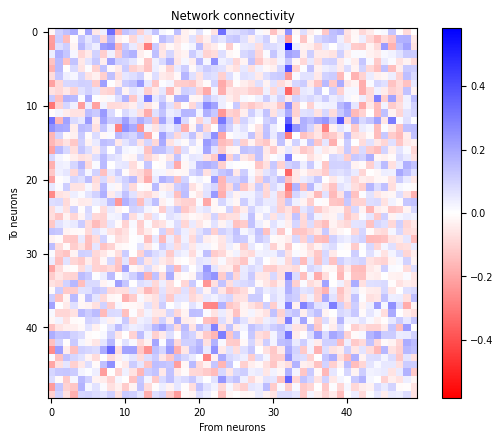

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.weight.detach().numpy()  # Access weight directly
# Sort by selectivity (for all neurons)
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

Shape of the neural activity (Time points, Neurons): (85000, 50)
Shape of the projected activity (Time points, PCs): (85000, 2)
Explained variance by PC1: 0.73, PC2: 0.16
Total explained variance by 2 PCs: 88.90%


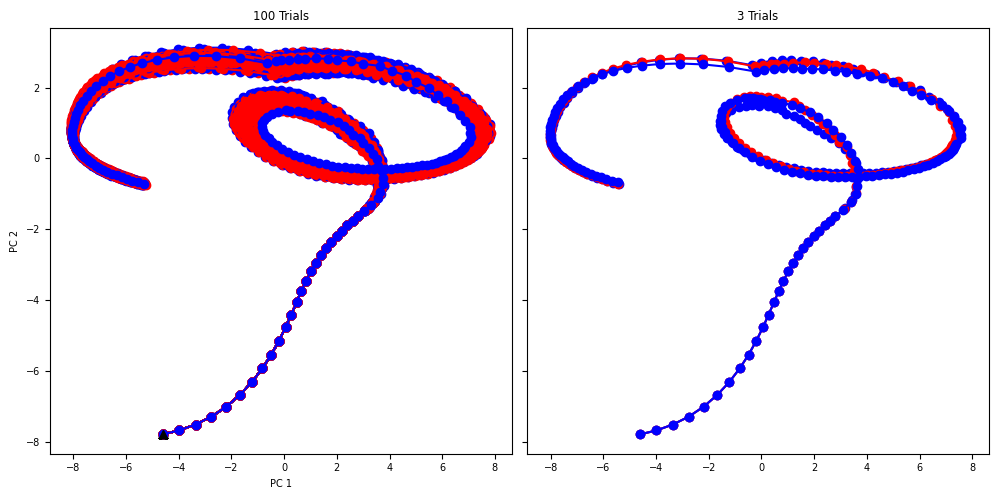

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

# Suppress excessive logging
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

# Number of trials to analyze
num_trial = 500

# Time points to visualize
plot_until_time = 200

# Gather activity data across trials
# Ensure activity_dict is populated during the model evaluation process
activity = np.concatenate([activity_dict[i] for i in activity_dict.keys()], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Perform PCA on the neural activity
pca = PCA(n_components=2)  # Use 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Project to lower dimensions
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Report the explained variance ratio for the components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}")
print(f"Total explained variance by 2 PCs: {sum(explained_variance) * 100:.2f}%")

# Visualize the PCA projections
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Loop through each trial
for i in range(100):  # Analyze and plot up to 100 trials
    trial_activity = activity_dict[i]  # Extract activity for the current trial
    trial_pc = pca.transform(trial_activity)  # Transform the trial activity

    # Color trials based on ground truth
    trial_info = trial_infos[i]
    color = 'red' if trial_info['ground_truth'] == 1 else 'blue'

    # Plot the trial data in the PCA space
    ax1.plot(trial_pc[:plot_until_time, 0], trial_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # For clarity, show only 3 trials on the second plot
        ax2.plot(trial_pc[:plot_until_time, 0], trial_pc[:plot_until_time, 1], 'o-', color=color)

    # Highlight the trial start with a black marker
    ax1.plot(trial_pc[0, 0], trial_pc[0, 1], '^', color='black')

# Add titles, labels, and adjust the layout
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

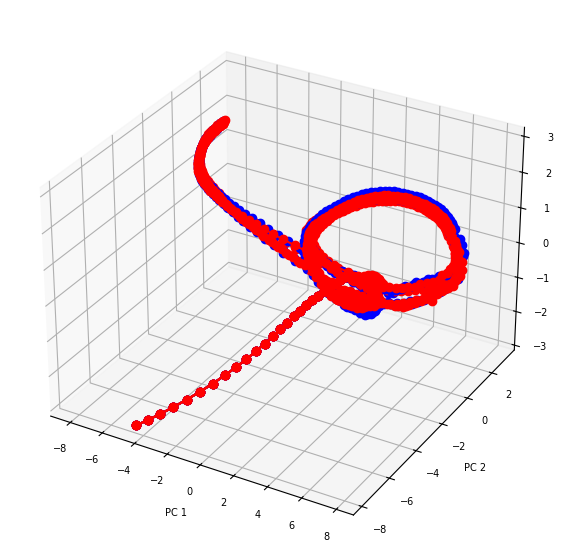

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(activity)
activity_pc = pca.transform(activity)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):  # Plot fewer trials for clarity
    trial_pc = pca.transform(activity_dict[i])
    trial_info = trial_infos[i]
    color = 'red' if trial_info['ground_truth'] == 1 else 'blue'
    ax.plot(trial_pc[:, 0], trial_pc[:, 1], trial_pc[:, 2], 'o-', color=color)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

### Lesioning

In [ ]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 100, Lesioned Network Loss 0.3869
Step 200, Lesioned Network Loss 0.3772
Step 300, Lesioned Network Loss 0.3816


*****************

*****************

**************

# Dendritic error model and EI mask

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


# Correct EIRecLinear with Dale's Law
class EIRecLinear(nn.Module):
    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size)  # Number of excitatory units
        self.i_size = hidden_size - self.e_size  # Number of inhibitory units

        # Weight matrix for recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Mask for Dale's law: Excitatory neurons (positive), Inhibitory neurons (negative)
        mask_no_diag = np.ones((hidden_size, hidden_size)) - np.eye(hidden_size)
        e_i_units = np.concatenate((np.ones(self.e_size), -1 * np.ones(self.i_size)))
        mask = mask_no_diag * e_i_units[:, None]
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optional bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        self.weight.data[:, :self.e_size] /= (self.e_size / self.i_size)  # Scale excitatory weights

        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        return F.relu(self.weight) * self.mask  # Apply mask and rectification

    def forward(self, input):
        return F.linear(input, self.effective_weight(), self.bias)


# Correct Leaky RNN with Dendritic Error Model
class LeakyRNNDenErrMod(nn.Module):
    def __init__(self, input_size, hidden_size, dt=None, learning_rate=0.01, e_prop=0.8):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(e_prop * hidden_size)  # Excitatory neuron count
        self.i_size = hidden_size - self.e_size  # Inhibitory neuron count
        self.learning_rate = learning_rate
        self.tau = 100  # Time constant in ms

        # Alpha factor for discretization
        self.alpha = dt / self.tau if dt else 1.0
        self.oneminusalpha = 1 - self.alpha

        # Input-to-hidden and hidden-to-hidden layers
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=e_prop)

        # Initialize dendritic voltages to zero
        self.dendritic_voltage = None

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

    def update_weights(self, input, hidden, dendritic_voltage, error):
        """Update weights using the dendritic error model."""
        voltage_diff = dendritic_voltage - hidden
        self.input2h.weight.data += self.learning_rate * torch.outer(input, voltage_diff * error)
        self.h2h.weight.data += self.learning_rate * torch.outer(hidden, voltage_diff * error)

    def recurrence(self, input, hidden, target=None):
        """Run a single time step."""
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        # Dendritic error computation
        error = None
        if target is not None:
            error = target - h_new
            if self.dendritic_voltage is None:
                self.dendritic_voltage = torch.zeros_like(h_new)
            self.update_weights(input, hidden, self.dendritic_voltage, error)

        # Leaky integration
        h_new = hidden * self.oneminusalpha + h_new * self.alpha

        # Update dendritic voltage
        if self.dendritic_voltage is not None:
            self.dendritic_voltage = h_new

        return h_new, error

    def forward(self, input, target=None, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(1)).to(input.device)

        output = []
        for t in range(input.size(0)):
            hidden, error = self.recurrence(input[t], hidden, target[t] if target is not None else None)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden


# Full RNN Model
class CombinedRNNDenErrNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=None, e_prop=0.8, learning_rate=0.01):
        super().__init__()
        self.rnn = LeakyRNNDenErrMod(input_size, hidden_size, dt=dt, e_prop=e_prop, learning_rate=learning_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, target=None):
        rnn_output, _ = self.rnn(input, target)
        output = self.fc(rnn_output)
        return output, rnn_output


Training network with corrected Leaky RNN and dendritic error model...
Step 100, Loss: 0.5909
Step 200, Loss: 0.3280
Step 300, Loss: 0.2732
Step 400, Loss: 0.2452
Step 500, Loss: 0.2344
Step 600, Loss: 0.2296
Step 700, Loss: 0.2200
Step 800, Loss: 0.2175
Step 900, Loss: 0.2168
Step 1000, Loss: 0.2113
Step 1100, Loss: 0.2099
Step 1200, Loss: 0.2095
Step 1300, Loss: 0.2059
Step 1400, Loss: 0.2040
Step 1500, Loss: 0.2053
Step 1600, Loss: 0.2013
Step 1700, Loss: 0.2005
Step 1800, Loss: 0.2010
Step 1900, Loss: 0.1974
Step 2000, Loss: 0.1978


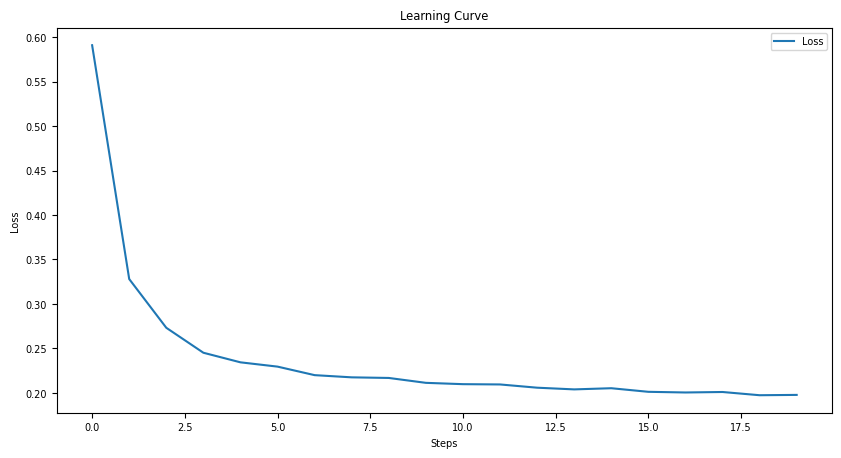

In [ ]:
# Training the corrected Leaky RNN with dendritic error model
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(net, dataset, num_steps=2000, lr=0.001):
    """
    Helper function to train the combined Leaky RNN with dendritic error and Dale's law.

    Args:
        net: A PyTorch nn.Module module representing the RNN.
        dataset: A dataset function that generates (input, target output) pairs.
        num_steps: Number of training steps.
        lr: Learning rate for the optimizer.

    Returns:
        net: The trained network object.
        loss_values: List of loss values recorded during training.
    """
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    running_loss = 0.0
    print_step = 100  # Steps interval for printing loss

    print("Training network with corrected Leaky RNN and dendritic error model...")
    for step in range(num_steps):
        # Generate input and target data from dataset
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float32)  # Convert inputs to torch tensor
        labels = torch.from_numpy(labels.flatten()).type(torch.long)  # Convert labels to torch tensor

        # Zero the gradient buffers
        optimizer.zero_grad()

        # Forward pass through the network
        output, _ = net(inputs)
        output = output.view(-1, output_size)  # Reshape to (Sequence Length x Batch Size, Output Size)

        # Compute loss
        loss = criterion(output, labels)

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Track and print running loss
        running_loss += loss.item()
        if step % print_step == (print_step - 1):
            avg_loss = running_loss / print_step
            print(f"Step {step + 1}, Loss: {avg_loss:.4f}")
            loss_values.append(avg_loss)
            running_loss = 0.0

    return net, loss_values


# Example Training Execution
hidden_size = 128
net = RNNDenErrNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
net, loss_values = train_model(net, dataset)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.title("Learning Curve")
plt.plot(loss_values, label="Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]
    stim_activity[env.trial['ground_truth']-1].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.484


Text(0, 0.5, 'Activity')

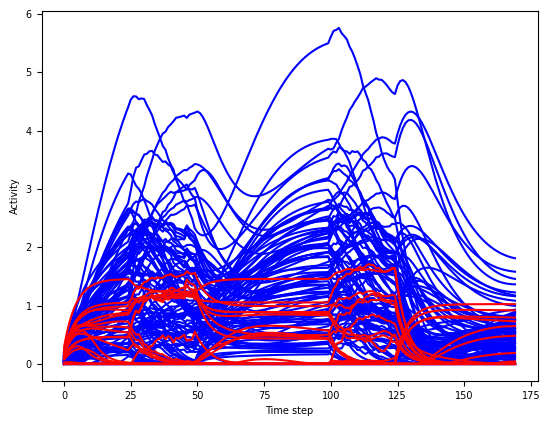

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

Text(0.5, 1.0, 'Network connectivity')

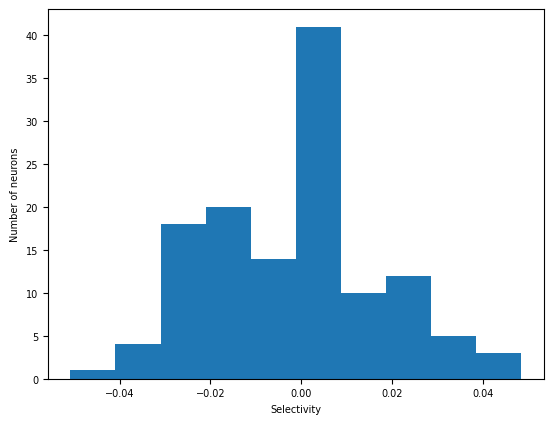

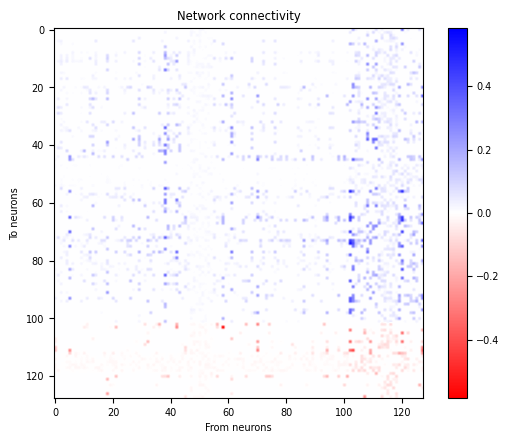

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

Shape of the neural activity (Time points, Neurons): (85000, 128)
Shape of the projected activity (Time points, PCs): (85000, 2)


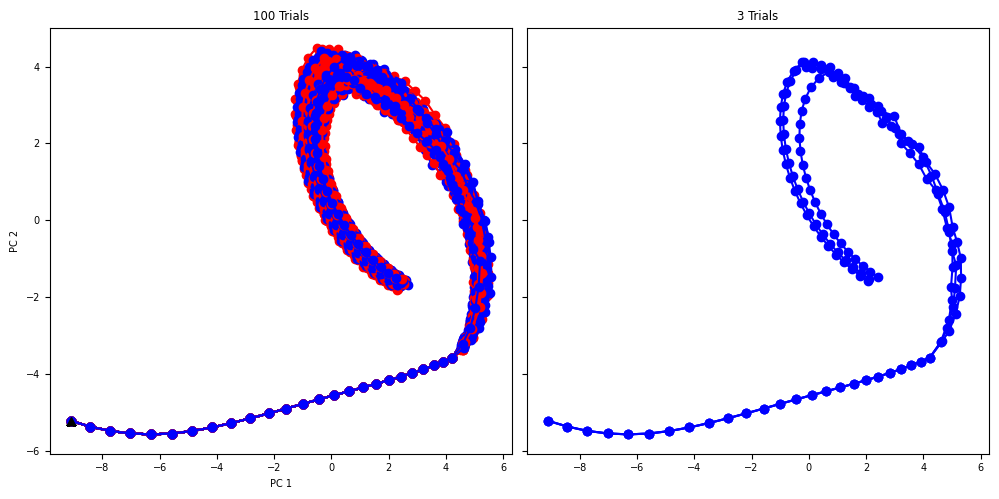

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

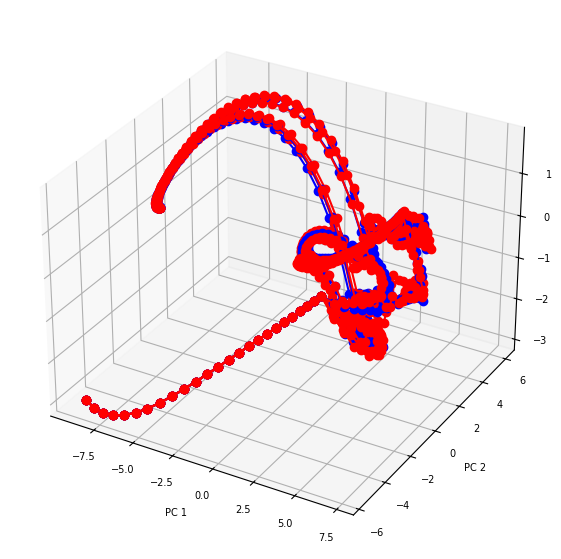

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(activity)
activity_pc = pca.transform(activity)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):  # Plot fewer trials for clarity
    trial_pc = pca.transform(activity_dict[i])
    trial_info = trial_infos[i]
    color = 'red' if trial_info['ground_truth'] == 1 else 'blue'
    ax.plot(trial_pc[:, 0], trial_pc[:, 1], trial_pc[:, 2], 'o-', color=color)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

### Lesioning

In [ ]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 100, Lesioned Network Loss 0.3206
Step 200, Lesioned Network Loss 0.3200
Step 300, Lesioned Network Loss 0.3160
